# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import numpy as np

In [4]:
import tensorflow as tf
import json
from matplotlib import pyplot as plt
import os
import cv2
import albumentations as alb
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D, AvgPool2D, MaxPooling2D, Flatten, Dropout, MaxPool2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
import random
from sklearn.model_selection import train_test_split


C:\Users\admin\anaconda3\envs\TF\lib\site-packages\tensorflow\python\framework\dtypes.py:513: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  np.object,


AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [17]:
import glob
images_path = glob.glob('anh_binh_thuong/*.jpg')
labels_path = glob.glob('labels/*.json')

In [18]:
print(len(labels_path))
print(len(images_path))

122
122


# AUGMENTATION

In [5]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                       bbox_params=alb.BboxParams(format='albumentations',
                                                  label_fields=['class_labels']))

In [31]:
labels_path[0]

'labels\\a_1.json'

# AUGUMENTATION

In [32]:
for i in range(len(images_path)):
  img = cv2.imread(images_path[i])
  image_name = images_path[i].split('\\')[1].split('.')[0]
  image_path = os.path.join('labels/', f'{image_name}.json')

  if os.path.exists(image_path):
    coords = [0,0,0,0]
    with open(image_path, 'r') as f:
      label = json.load(f)
    coords[0] = label['shapes'][0]['points'][0][0]
    coords[1] = label['shapes'][0]['points'][0][1]
    coords[2] = label['shapes'][0]['points'][1][0]
    coords[3] = label['shapes'][0]['points'][1][1]
    coords = list(np.divide(coords, [label['imageWidth'],label['imageHeight'],label['imageWidth'],label['imageHeight']]))

    for x in range(100):
      augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
      cv2.imwrite(os.path.join('aug/Images', f'{image_name}.{x}.jpg'), augmented['image'])

      annotation = {}

      if os.path.exists(image_path):
        if len(augmented['bboxes']) == 0:
          annotation['bbox'] = [0,0,0,0]
          annotation['class'] = 0
        else:
            annotation['bbox'] = augmented['bboxes'][0]
            annotation['class'] = 1
      else:
        annotation['bbox'] = [0,0,0,0]
        annotation['class'] = 0
      with open(os.path.join('aug/Labels', f'{image_name}.{x}.json'), 'w') as f:
        json.dump(annotation, f)
  else:
    for x in range(10):
      coords = [0,0,0.001,0.0001]
      augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
      cv2.imwrite(os.path.join('aug/Images', f'{image_name}.{x}.jpg'), augmented['image'])

      annotation = {}
      annotation['bbox'] = [0,0,0,0]
      annotation['class'] = 0


      with open(os.path.join('aug/Labels', f'{image_name}.{x}.json'), 'w') as f:
        json.dump(annotation, f)



# TEST

In [34]:
x = glob.glob('aug/Labels/*.json')
y = glob.glob('aug/Images/*.jpg')
print(len(x),len(y))

12200 12200


# DEFINE DATA


In [41]:
aug_images_path = glob.glob('aug/Images/*.jpg')
aug_labels_path = glob.glob('aug/Labels/*.json')
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [43]:
Images = []
Labels = []
for i in range(len(aug_images_path)):
  image_name = aug_images_path[i].split('\\')[1].split('.jpg')[0]
  for j in range(len(aug_labels_path)):
    label_name = aug_labels_path[j].split('\\')[1].split('.json')[0]
    if image_name == label_name:
      Images.append(aug_images_path[i])
      Labels.append(aug_labels_path[j])

del image_name, label_name,i,j

In [47]:
x_train, x_test, y_train, y_test = train_test_split(Images, Labels, test_size = 0.3)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, train_size = 0.2)

In [48]:
x_train = tf.data.experimental.from_list(x_train)
x_test = tf.data.experimental.from_list(x_test)
y_train = tf.data.experimental.from_list(y_train)
y_test = tf.data.experimental.from_list(y_test)
x_val = tf.data.experimental.from_list(x_val)
y_val = tf.data.experimental.from_list(y_val)

In [49]:
train_images = x_train.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [50]:
test_images = x_test.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)


val_images = x_val.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [51]:
del x_train, x_test,x_val

In [52]:
train_images.as_numpy_iterator().next()

array([[[0.54172796, 0.40447304, 0.3858456 ],
        [0.54656863, 0.40980393, 0.38480392],
        [0.5411765 , 0.40784314, 0.37254903],
        ...,
        [0.78302693, 0.700674  , 0.6889093 ],
        [0.78792894, 0.705576  , 0.6963848 ],
        [0.7916667 , 0.7019608 , 0.69558823]],

       [[0.54901963, 0.4117647 , 0.3925245 ],
        [0.5485294 , 0.41127452, 0.3877451 ],
        [0.545527  , 0.41170344, 0.3778799 ],
        ...,
        [0.7852941 , 0.7014706 , 0.6901961 ],
        [0.7838848 , 0.7015319 , 0.6966299 ],
        [0.7882353 , 0.7058824 , 0.70159316]],

       [[0.54901963, 0.4117647 , 0.3882353 ],
        [0.54901963, 0.4117647 , 0.3882353 ],
        [0.5495098 , 0.4122549 , 0.3887255 ],
        ...,
        [0.79264706, 0.6985294 , 0.6906863 ],
        [0.7921569 , 0.69803923, 0.6901961 ],
        [0.79607844, 0.7019608 , 0.69411767]],

       ...,

       [[0.6186274 , 0.4852941 , 0.5833333 ],
        [0.61519605, 0.48186275, 0.57941175],
        [0.6107843 , 0

In [53]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

In [54]:
train_labels = y_train.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
test_labels = y_test.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
val_labels = y_val.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [55]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [56]:
train.as_numpy_iterator().next()

(array([[[[0.8093137 , 0.74264705, 0.63284314],
          [0.8036152 , 0.73694855, 0.6193015 ],
          [0.8052083 , 0.73854166, 0.62873775],
          ...,
          [0.8637255 , 0.75392157, 0.74215686],
          [0.8511642 , 0.7413603 , 0.7261642 ],
          [0.83431375, 0.71960783, 0.7088235 ]],
 
         [[0.8096201 , 0.7429534 , 0.6331495 ],
          [0.8117647 , 0.74509805, 0.627451  ],
          [0.8117647 , 0.74509805, 0.63529414],
          ...,
          [0.87101716, 0.76121324, 0.74944854],
          [0.8598039 , 0.75      , 0.7348039 ],
          [0.84362745, 0.7289216 , 0.71813726]],
 
         [[0.8156863 , 0.7490196 , 0.6392157 ],
          [0.80876225, 0.7420956 , 0.62444854],
          [0.8122549 , 0.74558824, 0.6357843 ],
          ...,
          [0.8779412 , 0.76029414, 0.76029414],
          [0.8666667 , 0.75686276, 0.74509805],
          [0.847549  , 0.7372549 , 0.725     ]],
 
         ...,
 
         [[0.7647059 , 0.74509805, 0.6666667 ],
          [0.76470

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - img marked as output argument, but provided NumPy array marked as readonly
>  - Expected Ptr<cv::UMat> for argument 'img'
>  - img marked as output argument, but provided NumPy array marked as readonly
>  - Expected Ptr<cv::UMat> for argument 'img'


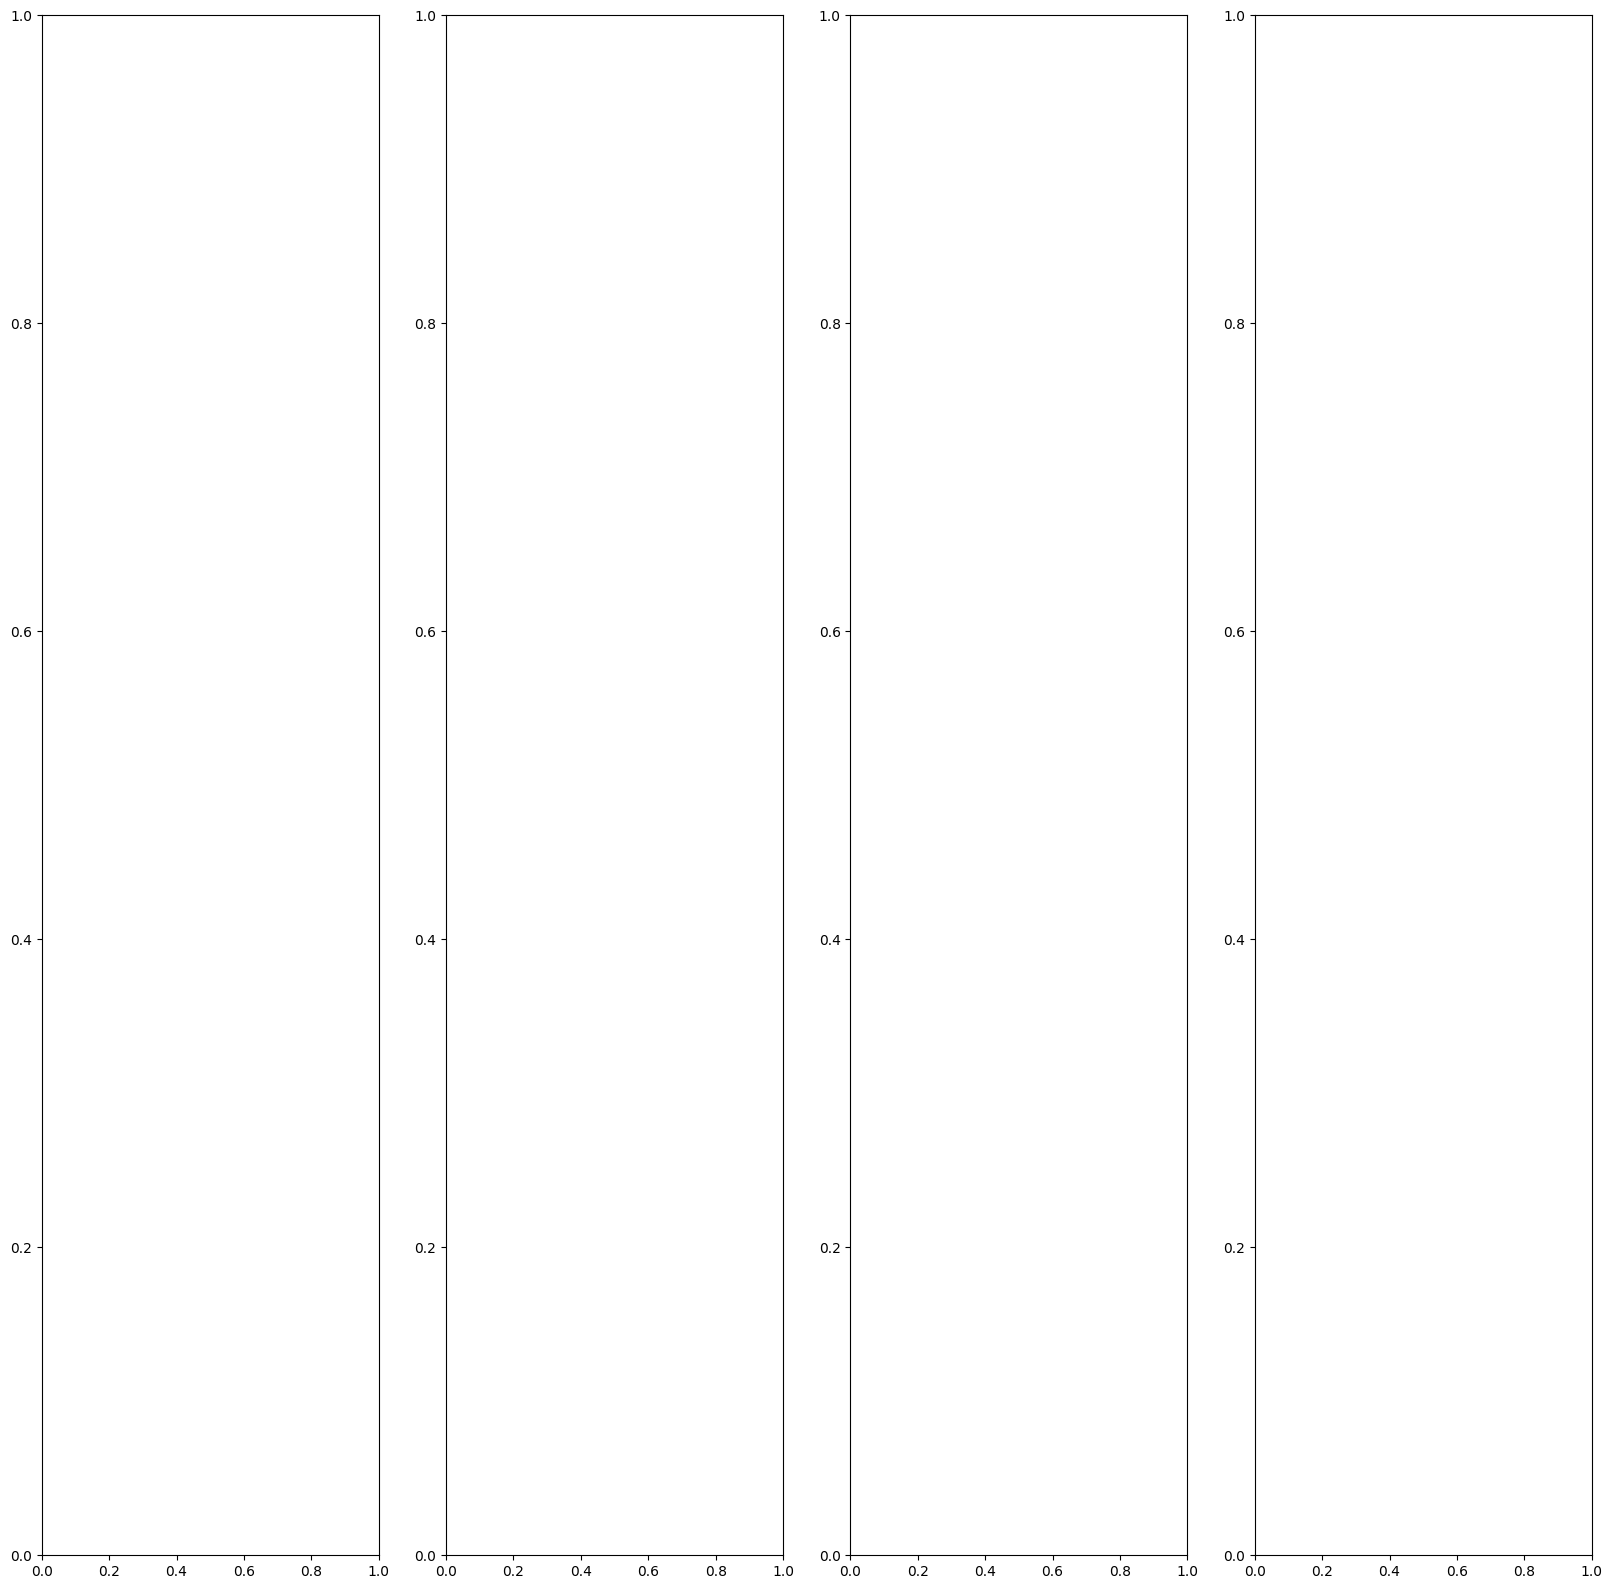

In [57]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# MODEL


In [58]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [59]:
vgg = VGG16(include_top=False)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [60]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [61]:
facetracker = build_model()
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [62]:
opt = tf.keras.optimizers.legacy.Adam(
    learning_rate=0.0001
)

In [63]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size


In [64]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [66]:
class FaceTracker(Model):
    def __init__(self, eyetracker,  **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss+1*batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+1*batch_classloss

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [67]:
model = FaceTracker(facetracker)
model.compile(opt, classloss, regressloss)

In [70]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[]

In [73]:
hist = model.fit(train, epochs=30, validation_data=val)

Epoch 1/30
  27/1068 [..............................] - ETA: 12:41 - total_loss: 0.4029 - class_loss: 0.0707 - regress_loss: 0.3322

KeyboardInterrupt: 

In [72]:
 export CUDA_VISIBLE_DEVICES='0'

SyntaxError: invalid syntax (2303595189.py, line 1)